# Import libraries

In [4]:
import sys
sys.path.insert(0,'..')

In [5]:
import os
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import colors
import numpy as np
from scipy import signal
import xarray as xr
from scipy.fft import fft, ifft

from src.utils.dataset_utils import *
from src.datasets.rb_fpa_prim_quench_ee_plateau import RBFPAPrimQuenchEEPlateau
from src.datasets.rb_fpa_prim_quench_ee_plateau2 import RBFPAPrimQuenchEEPlateau2
from src.utils.frequency_utils import *
from src.visualisation.fft_visualisation import plot_nmf_components, plot_position_frequency_map, plot_nmf_event_composition, plot_avg_component_weight, plot_component_distribution

pd.set_option('display.max_rows', 200)
import warnings
warnings.filterwarnings('ignore')

# Define Paths

In [6]:
file_path  = Path('/eos/project/m/ml-for-alarm-system/private/RB_signals')
data_path = file_path / 'backup/20220707_data'
simulation_path = file_path / 'backup/20220707_simulation'

# Read the (clean) MP3 file

In [7]:
mp3_fpa_df = pd.read_csv("../data/RB_TC_extract_2022_07_07_processed_filled.csv")
len(mp3_fpa_df)

3981

# Read Metadata

In [8]:
metadata_path = Path("../data/RB_metadata.csv")
rb_magnet_metadata = pd.read_csv(metadata_path, index_col=False)
rb_magnet_metadata

,Circuit,Magnet,Position,B1_aperture,Diode_type,Correctors,EE place,#Electric_EE,#Electric_circuit,Cryostat,...,age,Manufacturer,Inner cable type,Outer cable type,I_Q_SM18,Renamed short magnet ID,MTF Status,Magnet_construction_order,QPS Crate Number,Cryostat Number
0,RB.A12,MB.A8R1,276.7340,EXT,R,A,EVEN,1,78,LBARE.8R1,...,14.0,3.0,01B,02B8,11488.0,NaN,NaN,288,0,0
1,RB.A12,MB.B8R1,292.3940,EXT,R,B,ODD,77,77,LBBRF.8R1,...,14.0,2.0,01E,02C0,10622.0,NaN,NaN,256,0,1
2,RB.A12,MB.A9R1,315.7990,EXT,R,A,EVEN,2,79,LBARE.9R1,...,14.0,2.0,01E,02C9,12427.0,NaN,NaN,330,1,0
3,RB.A12,MB.B9R1,331.4590,EXT,R,B,ODD,76,76,LBBRG.9R1,...,14.0,2.0,01E,02C9,11155.0,NaN,NaN,319,2,1
4,RB.A12,MB.A10R1,356.2640,EXT,R,A,EVEN,3,80,LBARE.10R1,...,14.0,1.0,01E,02B8,11782.0,NaN,NaN,296,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1227,RB.A81,MB.A10L1,26302.6192,INT,L,B,ODD,75,75,LBBLG.10L1,...,14.0,3.0,01B,02G,12645.0,NaN,NaN,123,1,1
1228,RB.A81,MB.B9L1,26327.4242,INT,L,A,EVEN,2,79,LBALE.9L1,...,14.0,1.0,01B,02B5,12379.0,NaN,NaN,62,1,0
1229,RB.A81,MB.A9L1,26343.0842,INT,L,B,ODD,76,76,LBBLF.9L1,...,14.0,2.0,01B,02K,11757.0,NaN,NaN,61,2,1
1230,RB.A81,MB.B8L1,26366.4892,INT,L,A,EVEN,1,78,LBALE.8L1,...,14.0,3.0,01B,02G,11656.0,NaN,NaN,172,0,0


In [9]:
fpa_idx = "RB_RB.A34_1618728257120000000"
magnet_pos = 59

date = mp3_fpa_df[mp3_fpa_df.fpa_identifier == fpa_idx]['Timestamp_PIC'].values[0]
circuit = mp3_fpa_df[mp3_fpa_df.fpa_identifier == fpa_idx]['Circuit'].values[0]

In [10]:
magnet = rb_magnet_metadata[(rb_magnet_metadata.Circuit == circuit) & (rb_magnet_metadata['#Electric_circuit'] == magnet_pos)].Magnet.values[0]
print(f"Signal: {magnet.split('.')[1]} on {date.split('.')[0]} ")

Signal: B21R3 on 2021-04-18 08:44:17 


# Load data

In [11]:
dataset_path_1EE = Path("/eos/project/m/ml-for-alarm-system/private/RB_signals/backup/20220707_prim_ee_plateau_dataset")
dataset_path_2EE = Path("/eos/project/m/ml-for-alarm-system/private/RB_signals/backup/20220707_RBFPAPrimQuenchEEPlateau2")

dataset_creator_1EE = RBFPAPrimQuenchEEPlateau()
dataset_creator_2EE = RBFPAPrimQuenchEEPlateau2()

fpa_identifiers = mp3_fpa_df.fpa_identifier.unique()

dataset_1EE = dataset_creator_1EE.load_dataset(fpa_identifiers=fpa_identifiers,
                                       dataset_path=dataset_path_1EE,
                                       drop_data_vars=['simulation', 'el_position_feature', 'event_feature'])

#dataset_2EE = dataset_creator_2EE.load_dataset(fpa_identifiers=fpa_identifiers,
#                                       dataset_path=dataset_path_2EE,
#                                       drop_data_vars=['simulation', 'el_position_feature', 'event_feature'])

# Analyze Outliers

In [59]:
from src.utils.hdf_tools import load_from_hdf_with_regex
from src.visualisation.visualisation import plot_hdf

from src.utils.dataset_utils import align_u_diode_data, drop_quenched_magnets, u_diode_simulation_to_df, \
    u_diode_data_to_df, data_to_xarray, get_u_diode_data_alignment_timestamps

In [123]:
outlier_events = ["RB_RB.A78_1619330143440000000",
                  "RB_RB.A12_1621014819920000000",
                  "RB_RB.A45_1620797547820000000",
                  "RB_RB.A34_1620323722320000000"]

outlier_event = outlier_events[-1]
circuit = outlier_event.split('_')[1]

da_outlier = dataset_1EE.data.loc[{'event':outlier_event}]

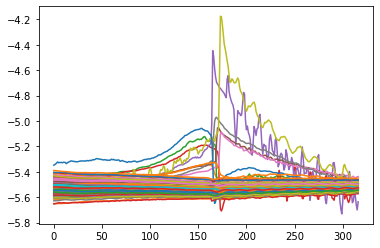

In [118]:
plt.plot(da_outlier.T)
plt.show()

In [124]:
magnet_id = np.argsort(np.nan_to_num(da_outlier.max(axis=1)))[::-1] + 1 

magnets_sorted = rb_magnet_metadata[rb_magnet_metadata['Circuit'] == circuit].set_index('El. Position', drop=True).loc[magnet_id, 'Magnet']
magnets_sorted

El. Position
120    MB.A32L4
78      MB.B8R3
118    MB.B33L4
36     MB.A33L4
35     MB.B32L4
119    MB.C32L4
34     MB.C31L4
33     MB.A31L4
37     MB.C33L4
122    MB.C30L4
105    MB.C27R3
31     MB.C29L4
8      MB.B14L4
58     MB.A22R3
25     MB.C25L4
99     MB.C23R3
121    MB.B31L4
38     MB.B34L4
14     MB.B18L4
150    MB.A12L4
91     MB.B18R3
57     MB.C22R3
21     MB.A23L4
39     MB.C34R3
71     MB.B13R3
59     MB.B21R3
32     MB.B30L4
86     MB.A15R3
17     MB.B20L4
62     MB.B19R3
133    MB.B23L4
112    MB.B32R3
144    MB.A16L4
131    MB.C24L4
81     MB.B11R3
2       MB.B9L4
5      MB.B12L4
94     MB.B20R3
18     MB.A21L4
147    MB.A14L4
70     MB.A14R3
96     MB.C21R3
53     MB.B25R3
24     MB.A25L4
115    MB.B34R3
123    MB.A30L4
65     MB.B17R3
117    MB.A34L4
152    MB.A10L4
7      MB.C13L4
124    MB.B29L4
85     MB.B14R3
93     MB.C19R3
29     MB.B28L4
27     MB.A27L4
137    MB.C20L4
146    MB.C14L4
116    MB.C34L4
113    MB.A33R3
30     MB.A29L4
136    MB.B21L4
87     MB.C

In [127]:
mp3_fpa_df[(mp3_fpa_df['Circuit Name'] == circuit) & (mp3_fpa_df['Position'] == magnets_sorted.iloc[0].split('.')[-1])].fpa_identifier

1389    RB_RB.A34_1617560138980000000
1545    RB_RB.A34_1618378572280000000
2154    RB_RB.A34_1620323722320000000
Name: fpa_identifier, dtype: object

In [99]:
data_path = Path("/eos/project/m/ml-for-alarm-system/private/RB_signals/20220707_data")

data_dir = data_path / (outlier_event + ".hdf5")
data = load_from_hdf_with_regex(file_path=data_dir, regex_list=['VoltageNQPS.*U_DIODE'])
df_data = u_diode_data_to_df(data, len_data=len(data[0]))

Text(0.5, 1.0, 'MB.B28L8')

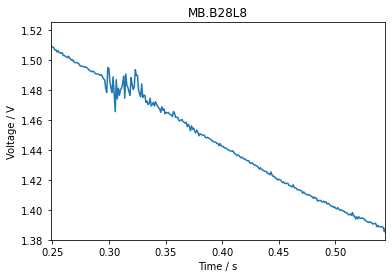

In [105]:
df_data[magnets_sorted.iloc[0]+':U_DIODE_RB'].plot(legend=False)
plt.xlim((dataset_1EE.time[0], dataset_1EE.time[-1]))
plt.ylim((1.38,1.525))
plt.xlabel('Time / s')
plt.ylabel('Voltage / V')
plt.title(magnets_sorted.iloc[0])

# FFT Analysis

In [6]:
dataset_1EE_detrend = dataset_creator_1EE.detrend_dim(dataset_1EE)
#dataset_2EE_detrend = dataset_creator_2EE.detrend_dim(dataset_2EE)

f_window=np.hamming
f_lim=(0, 500)
dataset_1EE_fft = get_fft_of_DataArray(data=dataset_1EE_detrend.data, f_window=f_window, f_lim=f_lim)
#dataset_2EE_fft = get_fft_of_DataArray(data=dataset_2EE_detrend.data, f_window=f_window)

dataset_1EE_ifft = get_ifft_of_DataArray(data=dataset_1EE_fft, f_window=f_window)
#dataset_2EE_ifft = get_ifft_of_DataArray(data=dataset_2EE_fft, f_window=f_window)

dataset_1EE_fft_amplitude = scale_fft_amplitude(data=dataset_1EE_fft, f_window=f_window)
#dataset_2EE_fft_amplitude = scale_fft_amplitude(data=dataset_2EE_fft, f_window=f_window)

In [7]:
dataset_1EE_fft_real= scale_fft_amplitude(data=dataset_1EE_fft_amplitude, f_window=f_window, is_polar=True)
_ , dataset_1EE_fft_phase = complex_to_polar(dataset_1EE_fft)

dataset_1EE_fft2 = polar_to_complex(dataset_1EE_fft_real, dataset_1EE_fft_phase)
dataset_1EE_ifft2 = get_ifft_of_DataArray(data=dataset_1EE_fft2, f_window=f_window)

# Test differtent window functions

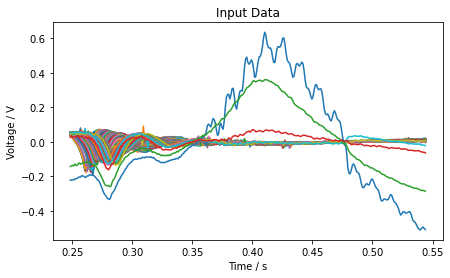

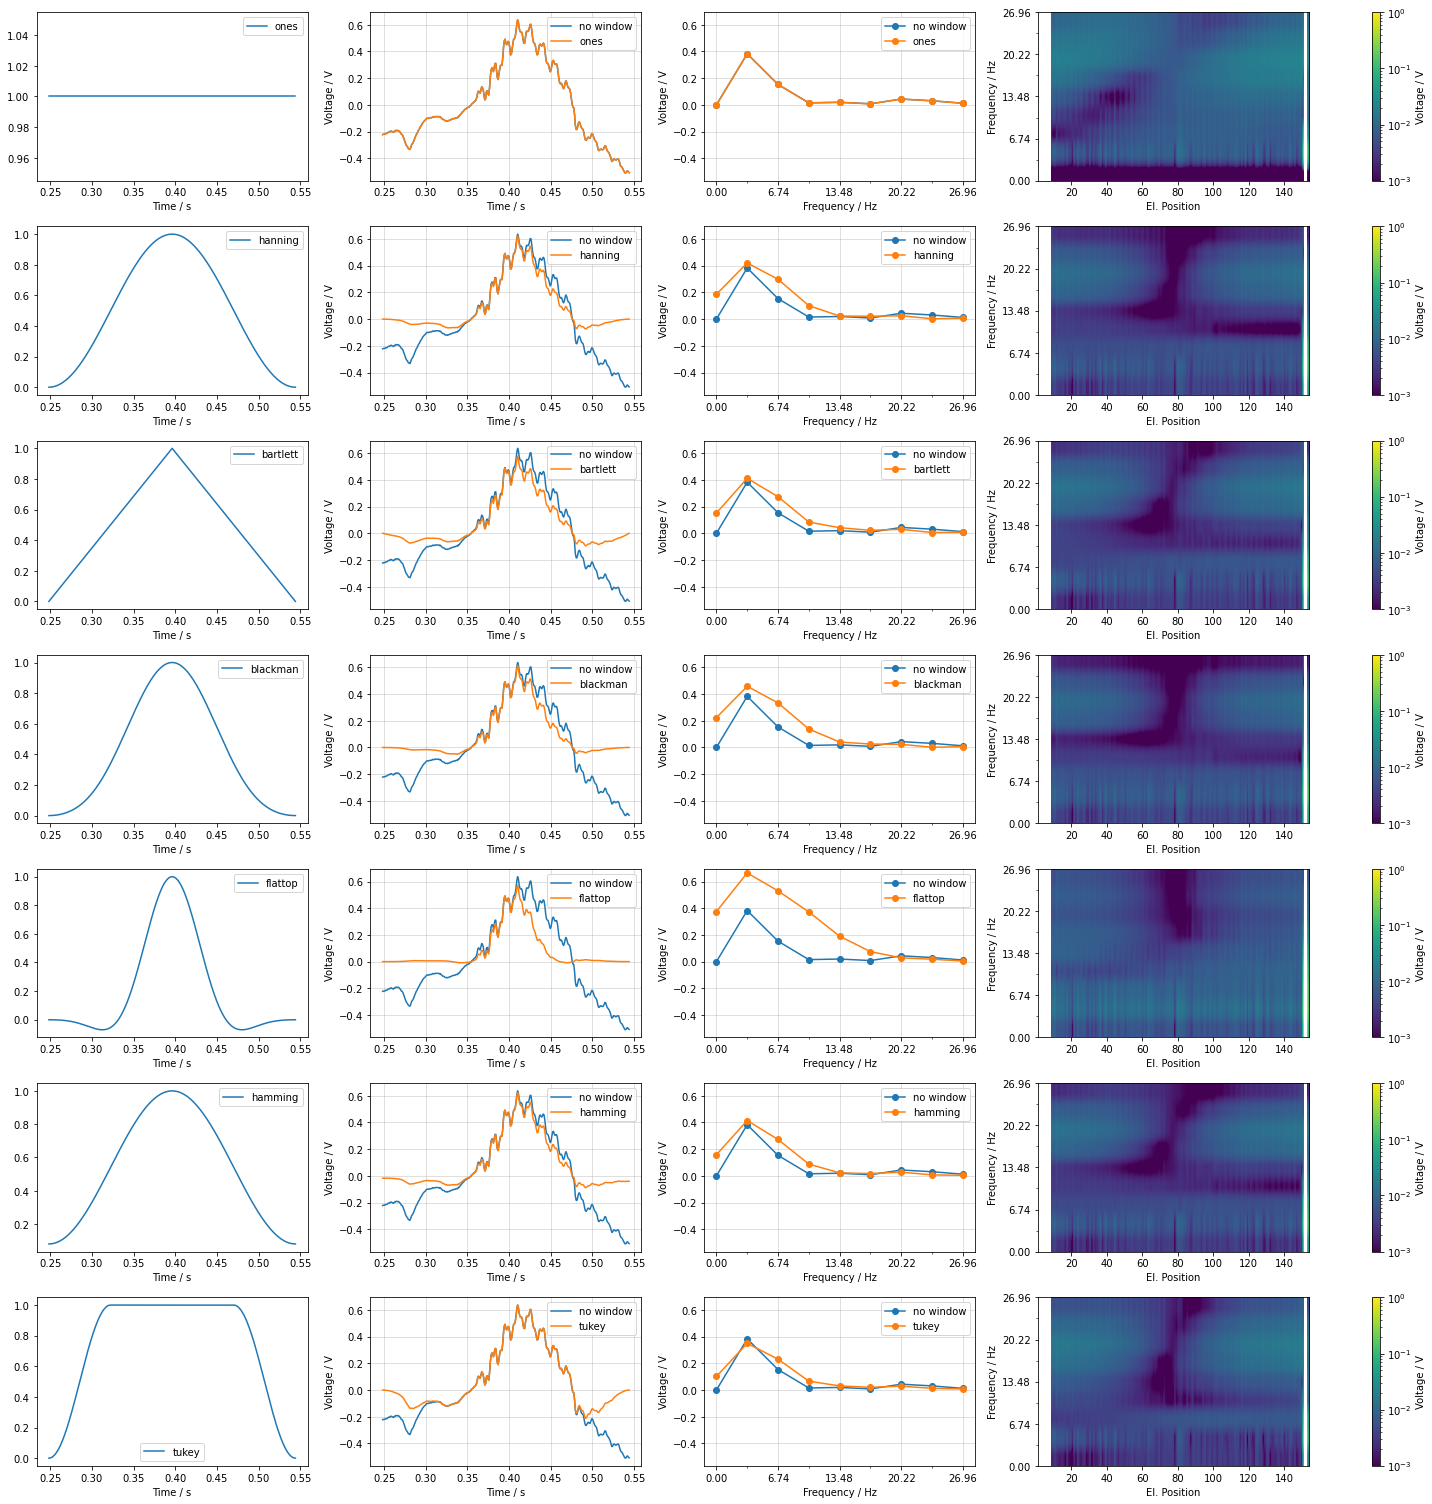

In [8]:
event = 2
magnet = 150
vmin = 1e-3
vmax = 1
max_freq = 30
data = dataset_1EE_detrend.data
fft_windows = [np.ones, np.hanning, signal.windows.bartlett, signal.windows.blackman, signal.windows.flattop, signal.windows.hamming, signal.windows.tukey]   

fig, ax = plt.subplots( figsize=(7, 4))
ax.plot(data.time, data[event].T)
ax.set_title("Input Data")
ax.set_ylabel('Voltage / V')
ax.set_xlabel('Time / s')
plt.show()

dataset_1EE_fft_nowin = get_fft_of_DataArray(data=data.isel(event=[event]), f_window=np.ones)
amplitude_nowin = scale_fft_amplitude(data=dataset_1EE_fft_nowin, f_window=np.ones)
amplitude_nowin = amplitude_nowin.where(amplitude_nowin.frequency < max_freq, drop=True)

fig, ax = plt.subplots(len(fft_windows),5, figsize = (20,3 * len(fft_windows)), gridspec_kw={'width_ratios': [4, 4, 4, 4, 0.5]})
for i, f_window in enumerate(fft_windows):
    dataset_1EE_fft_event = get_fft_of_DataArray(data=data.isel(event=[event]), f_window=f_window)
    amplitude = scale_fft_amplitude(data=dataset_1EE_fft_event, f_window=f_window)
    
    amplitude = amplitude.where(amplitude_nowin.frequency < max_freq, drop=True)
    
    window = f_window(len(data[event, magnet,:]))
    
    
    ax[i, 0].plot(data.time, window, label=f_window.__name__)
    ax[i, 0].set_xlabel('Time / s')
    ax[i, 0].legend()
    
    ax[i, 1].plot(data.time, data[event, magnet], label="no window")
    ax[i, 1].plot(data.time, data[event, magnet] * window, label=f_window.__name__)
    ax[i, 1].set_xlabel('Time / s')
    ax[i, 1].set_ylabel('Voltage / V')
    ax[i, 1].legend()
    ax[i, 1].grid(alpha=0.5)  
    

    ax[i, 2].plot(amplitude.frequency, amplitude_nowin[0, magnet], "-o", label="no window")
    ax[i, 2].plot(amplitude.frequency, amplitude[0, magnet], "-o", label=f_window.__name__)
    ax[i, 2].set_xlabel('Frequency / Hz')
    ax[i, 2].set_ylabel('Voltage / V')
    ax[i, 2].legend()
    ax[i, 2].set_xticks(amplitude.frequency.values, minor=True)
    ax[i, 2].set_xticks(amplitude.frequency.values[::2])
    ax[i, 2].grid(alpha=0.5)  
    ax[i, 2].set_ylim(ax[i, 1].get_ylim())  
    
    im = plot_position_frequency_map(ax[i, 3], amplitude, amplitude.frequency, vmin=vmin, vmax=vmax)
    ax[i, 3].set_ylabel('Frequency / Hz')
    ax[i, 3].set_xlabel('El. Position')
    ax[i, 3].set_yticks(amplitude.frequency.values, minor=True)
    ax[i, 3].set_yticks(amplitude.frequency.values[::2])

    cbar = fig.colorbar(im, ax=ax[i, 4], fraction=1)
    ax[i, 4].set_axis_off()
    cbar.set_label('Voltage / V')
    plt.tight_layout()

# Check Amplitudes

In [14]:
def plot_time_fft_comparison(data, data_fft, dataset_ifft):
    fig, ax = plt.subplots(1,2, figsize=(20, 5), gridspec_kw={'width_ratios': [1, 0.3]})

    ax[0].plot(data.time, data, label="signal")
    #ax[0].plot(data.time, np.real(dataset_ifft), label="reconstruction")
    #ax[0].plot(data.time, np.imag(dataset_ifft), label="imag")
    #ax[0].plot(data.time, np.abs(dataset_ifft), label="real")
    ax[0].legend()
    
    ax[1].plot(data_fft.frequency, data_fft.data, "-o")
    mean_amplitude = np.nanmean(np.abs(dataset_ifft.values[1:-1]))
    ax[1].plot(data_fft.frequency, np.ones(len(data_fft.frequency)) * mean_amplitude)
    
    

    ax[0].grid()
    ax[1].grid()

    ax[0].set_title("time-series")
    ax[1].set_title("frequency")

    ax[0].set_xlim((data.time[0], data.time[-1]))
    ax[0].set_xticks(np.arange(np.round(data.time[0].values, 2), np.round(data.time[-1].values, 2), 0.02))

    ax[1].set_xlim((data_fft.frequency[0], data_fft.frequency[-1]))
    ax[1].set_ylim(ax[0].get_ylim())
    ax[1].set_xticks(data_fft.frequency.values[::3].astype(int))
    ax[1].set_xlim((0,100))

    plt.tight_layout()
    plt.show()

NameError: name 'dataset_2EE' is not defined

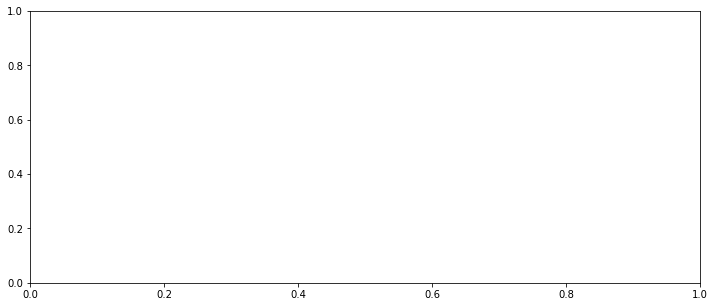

In [10]:
for i in np.arange(46,47):    
    fig, ax = plt.subplots( figsize=(12, 5))
    ax.plot(dataset_2EE.time, dataset_2EE.data[i].T)
    ax.set_title("Input Data")
    ax.set_ylabel('Voltage / V')
    ax.set_xlabel('Time / s')
    idx_larges_signal = np.nan_to_num(dataset_2EE.data[i].values).max(axis=1).argmax()
    ax.set_title(f"{i} , {idx_larges_signal}")
    plt.show()

In [18]:
event

110

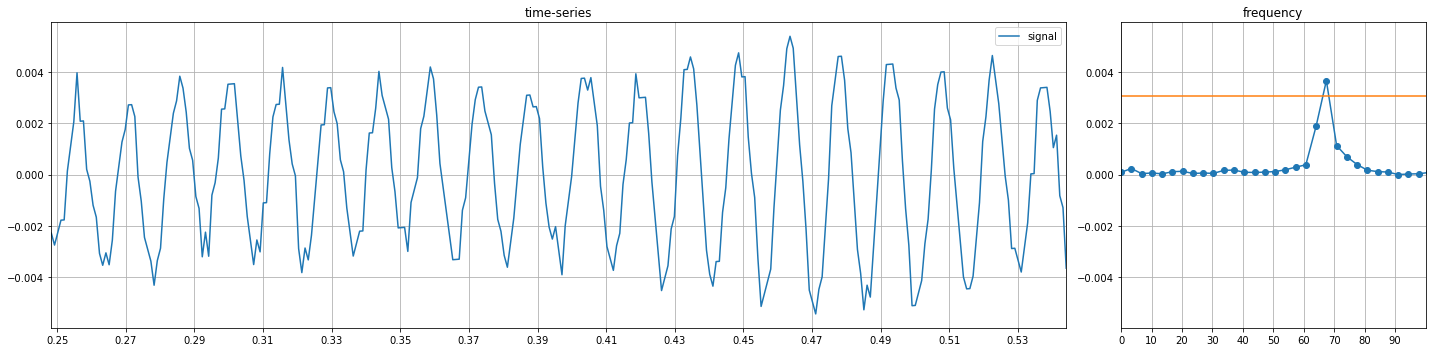

In [17]:
fpa_idx = "RB_RB.A34_1618728257120000000"
event = np.arange(len(dataset_1EE.event))[dataset_1EE.event == fpa_idx][0]
magnet = 59

plot_time_fft_comparison(dataset_1EE_detrend.data[event,magnet], dataset_1EE_fft_amplitude[event,magnet], dataset_1EE_ifft[event,magnet])

In [12]:
event = 46
magnet = 44 
plot_time_fft_comparison(dataset_2EE_detrend.data[event,magnet], dataset_2EE_fft_amplitude[event,magnet], dataset_2EE_ifft[event,magnet])

NameError: name 'dataset_2EE_detrend' is not defined

# Aliasing Filters Bode plot

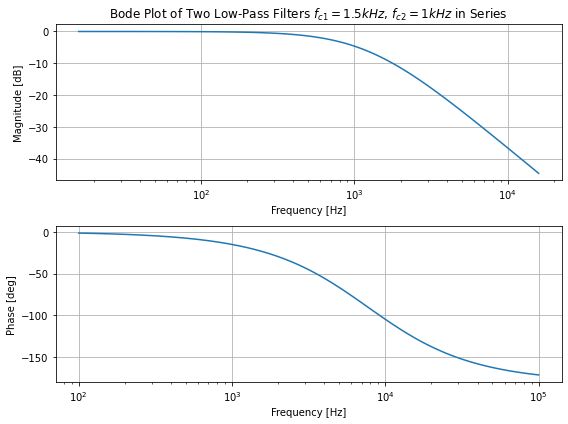

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

# Define the cutoff frequencies of the two filters
fc1 = 1000 # 1 kHz
fc2 = 1500 # 1.5 kHz

# Create a transfer function for the first filter
num1 = [fc1 * 2 * np.pi]
den1 = [1, fc1 * 2 * np.pi]
tf1 = signal.TransferFunction(num1, den1)

# Create a transfer function for the second filter
num2 = [fc2* 2 * np.pi]
den2 = [1, fc2 * 2 * np.pi]
tf2 = signal.TransferFunction(num2, den2)

# Compute the frequency response of the two filters
w1, mag1, phase1 = signal.bode(tf1)
w2, mag2, phase2 = signal.bode(tf2)

# Compute the total frequency response of the two filters in series
mag = mag1 + mag2
phase = phase1 + phase2

# Create the bode plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))
plt.subplots_adjust(hspace=0.5)

#ax1.semilogx(w1 / (2 * np.pi), mag1)
#ax1.semilogx(w2 / (2 * np.pi), mag2)
ax1.semilogx(w1/ (2 * np.pi), mag)
ax1.set_title('Bode Plot of Two Low-Pass Filters $f_{c1}=1.5 kHz$, $f_{c2}=1 kHz$ in Series')
ax1.set_xlabel('Frequency [Hz]')
ax1.set_ylabel('Magnitude [dB]')
#ax1.set_ylim((-10,0))
ax1.grid()

ax2.semilogx(w1, phase)
ax2.set_xlabel('Frequency [Hz]')
ax2.set_ylabel('Phase [deg]')
ax2.grid()

plt.tight_layout()
plt.show()